## Preparing Environement

In [75]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from data import preprocessing as prp
%aimport data.preprocessing
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())


#printing
pd.options.display.float_format = '{:,.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load preprocessed data

In [245]:
subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

v=1

season = "Spring"
raw_file_name ="product_p2_raw_%s"%season
clean_file_name = "product_p2_clean_%s"%season
z_file_name ="product_z_p2_clean_%s"%season


row_headers = ['Product','Client']
row_headers = ['Product']
n_row_headers = len(row_headers)

product_raw_df = prp.load_file(raw_file_name,version = v)
product_df = prp.load_file(clean_file_name,version = v)
product_df_full = prp.load_file(z_file_name, type_="P",version = v)




In [246]:
X_train, X_test = train_test_split(product_df_full, test_size=0.25)
prp.save_file(X_test,"test",type_="P")

X_train = product_df_full.copy()

X_z = X_train.values[:,n_row_headers:].astype(np.float64)

nb_col = X_z.shape[1]
X_pca = PCA(n_components = nb_col).fit_transform(X_z)
prp.display(product_df_full)

(1063, 17)


Product     1     2     3     4     5     6     7     8     9    10  \
0  31C001001_2 -1.92 -1.42 -1.21 -1.02 -0.85  0.08  0.65  0.77  0.27 -0.11   
1  31C901903_2 -0.65  0.48  1.50  2.06  1.71  0.93  0.40 -0.28 -0.53 -0.72   
2  325015903_2 -1.34 -0.12 -0.12  0.50 -0.73  1.11 -0.12 -0.12 -1.96 -0.73   
3  325018000_2 -1.13 -1.08 -1.05 -1.03 -1.00 -0.84 -0.62 -0.15  1.21  1.76   
4  325018200_2 -1.30 -1.16 -1.07 -1.06 -0.95 -0.68 -0.43 -0.13  1.13  1.58   

     11    12    13    14    15    16  
0  0.01  0.10  0.55  1.55  1.31  1.24  
1 -0.82 -0.82 -0.82 -0.82 -0.82 -0.82  
2  0.50  1.11  1.73  1.11  0.50 -1.34  
3  1.75  0.80  0.68  0.66  0.28 -0.25  
4  1.83  0.92  0.83  0.59  0.21 -0.30

# 3. Modeling - Clustering Algorithms
Try out Hierarchical clustering, kMeans and kMedodis  on raw (cleaned) data. Then, plot the PCA to visualize the result of the clustering on the principal components

## Agglomerative - Automated Cut-Off Selection

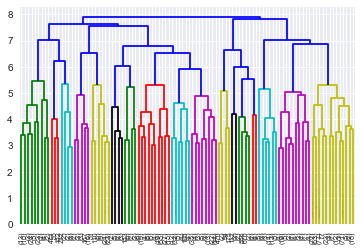

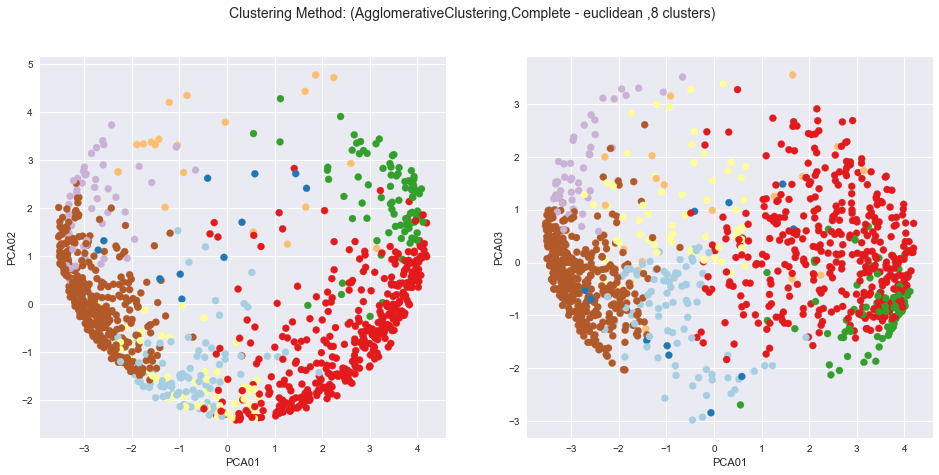

In [32]:
from scipy.cluster import hierarchy

SSE = {}
SILOUHAITE = {}

Z = hierarchy.linkage(X_z, method='complete',metric='euclidean')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels_h_cc = hierarchy.fcluster(Z, t=8 ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels_h_cc,info=["AgglomerativeClustering","Complete - euclidean ","%d clusters"%len(set(labels_h_cc))])


SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

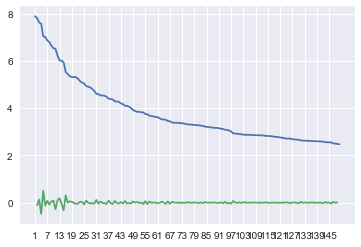

clusters: [  5   4  15  16  11  13   3   6  31   2  12  26  37  10   8  25   7  40
  98  45  55  14  18  54  56  39  36  65  66  49  21  57  33  67  97   9
  22  32  23  63  42  30 146  68  46  51  44  94  61 147 131  95  19  48
  24  28  93 130  35 143  43  29 103  47  83 126  76 142  81  84 102  38
  92 101 124  52  27 114 100  73  69  90  91  41  79 128  82  89 108 107
 135  34  71 127  20  77 149 136 116 133  58 148  62  53  99 115 144 111
 112 132  75  96  72 121  60 145  64 137 118 119  59  17 139  78 134  86
 120 104  74 141 123 129 117  85 125 113 106  87 138 140  88  80 122  70
 109  50 105 110]


In [33]:
last = Z[-150:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last),6))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

### K-Means: Validate different numbers of clusters

clusters: [15 12 13 17 18 14 16 20]
clusters: [12 10 18 11 16 14 15 17 20 13]


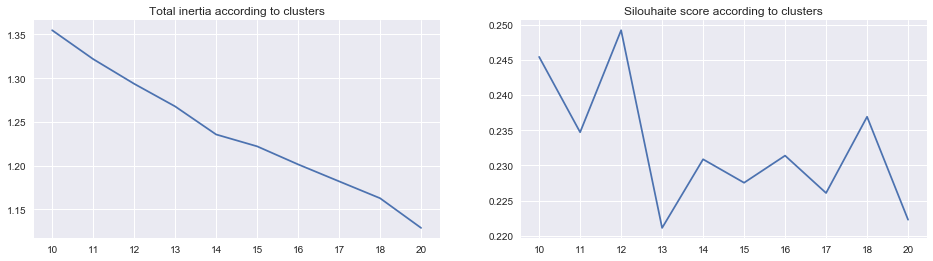

In [9]:
%matplotlib inline
clusters= np.linspace(10,20,10).astype(int)
inertia = []
silouhaite = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster).fit(X_z)
    silouhaite.append(hlp.getSilouhaite(X_z,kmeans.labels_))
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])


plt.show()


## Ward Clustering

19963.4003152


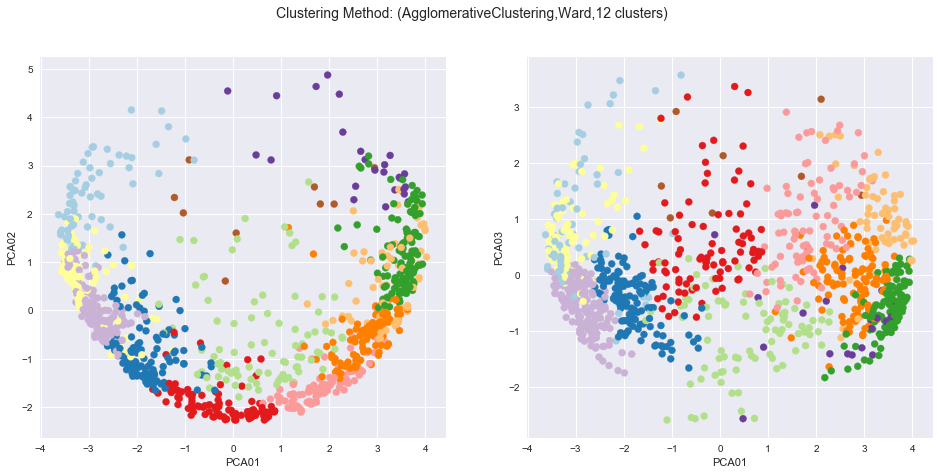

In [10]:
n_cluster = 12

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
print(SSE['Ward'])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## K-means

In [11]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

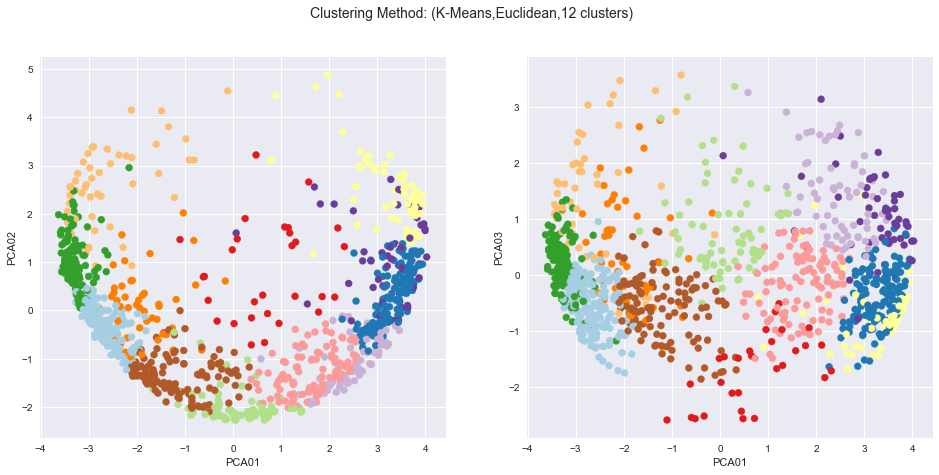

In [12]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

## Custom Distances

In [163]:
from scipy.stats import spearmanr
def spearmanr_dist(x,y):
    rho, pval = spearmanr(x,y)
    return rho


r,p = spearmanr(X_z)
np.fill_diagonal(r,0)

In [247]:
from external import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))
sqcorr_distance = corr_distance**2
#spearman_distance = squareform(pdist(X_z, lambda u, v: spearmanr_dist(u,v)))

## K-medoid: validate number of clusters using silouhaite

clusters: [ 7 15 11 12 10  9  8 13]
clusters: [ 5  6  9 10  8  7 12 11 13 15]


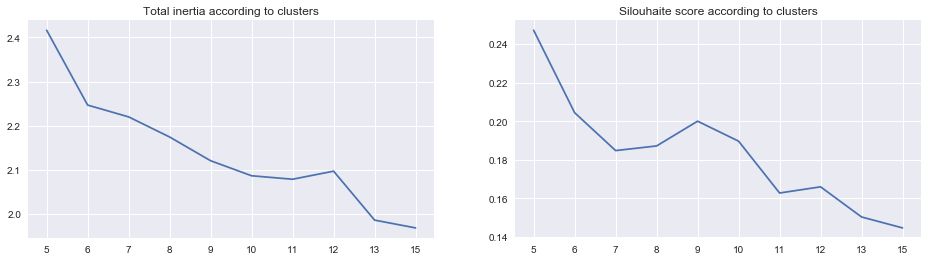

In [248]:
%matplotlib inline
clusters= np.linspace(5,15,10).astype(int)
silouhaite = []
inertia = []
for cluster in clusters:
    labels_kmedoids, medoids = kMedoids.cluster(euclid_distance,k= cluster)
    silouhaite.append(hlp.getSilouhaite(X_z,labels_kmedoids))
    sse = hlp.getSSE(X_z,X_z[labels_kmedoids])
    inertia.append(np.sqrt(sse/len(labels_kmedoids)))
    

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])

## K-medoids Clustering

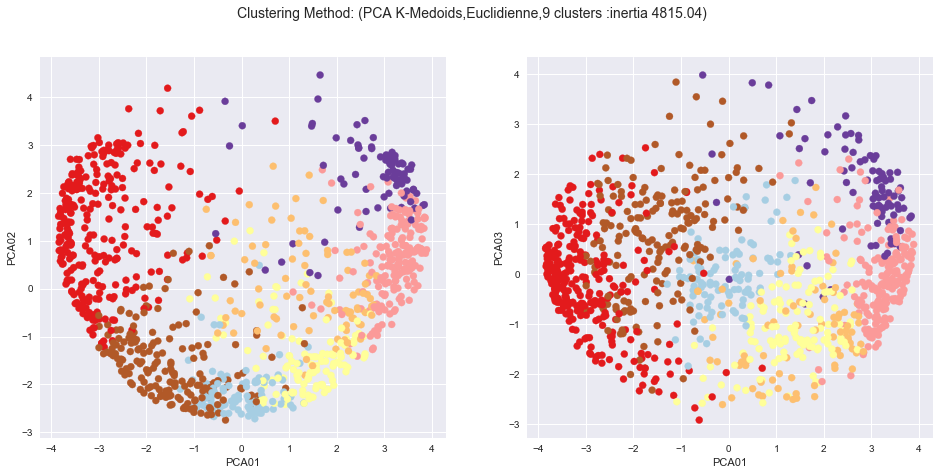

In [249]:
n_cluster = 9
label, medoids_euc = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

# labels_kmedoids_corr,medoids_corr = kMedoids.cluster(corr_distance,k= n_cluster)
# labels_kmedoids_spear,medoids_spear = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
# SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])
# SSE["kMedoids_spear"] = hlp.getSSE(X_z,X_z[labels_kmedoids_spear])


SILOUHAITE["kMedoids"] = hlp.getSilouhaite(X_z,labels_kmedoids)
# SILOUHAITE["kMedoids_corr"] = hlp.getSilouhaite(X_z,labels_kmedoids_corr)
# SILOUHAITE["kMedoids_spear"] = hlp.getSilouhaite(X_z,labels_kmedoids_spear)


hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])

### t-SNE representation of the clustering

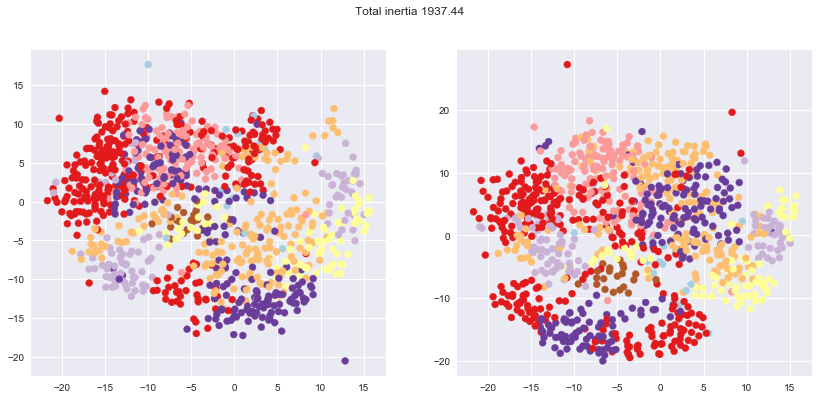

In [22]:
X_tsne = TSNE(n_components = 3).fit_transform(X_z)

plt.figure(figsize=(14,6))
colors = np.array([str(item/255.) for item in labels_kmedoids])
plt.suptitle("Total inertia %.02f"%SSE["kMedoids"])  
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0],X_tsne[:,1],cmap ="Paired" ,c=colors)
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0],X_tsne[:,2],cmap ="Paired" ,c=colors)
plt.show(block = True)

## Clustering methods Metrics

In [250]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

print()
    
for k,v in SILOUHAITE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "kMedoids" : 4815.04
 "kMedoids_spear" : 3262.29
 "kMedoids_corr" : 3473.60
 "Agg_complete" : 23289.49

 "kMedoids" : 0.17
 "kMedoids_spear" : 0.16
 "kMedoids_corr" : 0.15


# Save Clustering Results

In [251]:
version = 1

file_name = "p2_clustering_clean_week_%s_v%d.csv"%(season,version)


def labels_to_df(labels,data_df_full):
    medoid_cluster_dict = dict()
    
    medoids = list(set(labels))
    for i,l in enumerate(medoids):
        medoid_cluster_dict[l] = i+1

    pd_tuples_list = list(data_df_full[row_headers].itertuples(index=False))
    headers_list = [tuple(x) for x in pd_tuples_list]
    
    rows=[]
    for i,h in enumerate(headers_list):
        m = labels[i]
        rows.append([h[0],medoid_cluster_dict[m],"%s"%headers_list[m]])


    label_df = pd.DataFrame(rows,columns = row_headers + ["Cluster","Centroid"])
    return label_df


eucl_df = labels_to_df(labels_kmedoids,X_train)
# corr_df = labels_to_df(labels_kmedoids_corr,product_df_full)
# spear_df = labels_to_df(labels_kmedoids_spear,product_df_full)



eucl_df.to_csv(models_path+"%s_euc_"%PREFIX+file_name, sep=';', encoding='utf-8')
# corr_df.to_csv(models_path+"%s_corr_"%PREFIX+file_name, sep=';', encoding='utf-8')
# spear_df.to_csv(models_path+"%s_pear_"%PREFIX+file_name, sep=';', encoding='utf-8')


print(eucl_df.shape)
eucl_df.head()

(1063, 3)


Product  Cluster     Centroid
0  31C001001_2        3  331995215_2
1  31C901903_2        5  336009400_2
2  325015903_2        9  332979714_2
3  325018000_2        2  331995212_2
4  325018200_2        2  331995212_2

In [252]:
eucl_df = prp.load_file("euc_p2_clustering_clean_week_%s"%season,version=1,type_="M").drop("Unnamed: 0",axis=1)
eucl_df.Centroid = eucl_df.Centroid.apply(lambda x:str("('%s',)"%x))
eucl_df.head()

Product  Cluster          Centroid
0  31C001001_2        3  ('331995215_2',)
1  31C901903_2        5  ('336009400_2',)
2  325015903_2        9  ('332979714_2',)
3  325018000_2        2  ('331995212_2',)
4  325018200_2        2  ('331995212_2',)

# Display Clustering Results

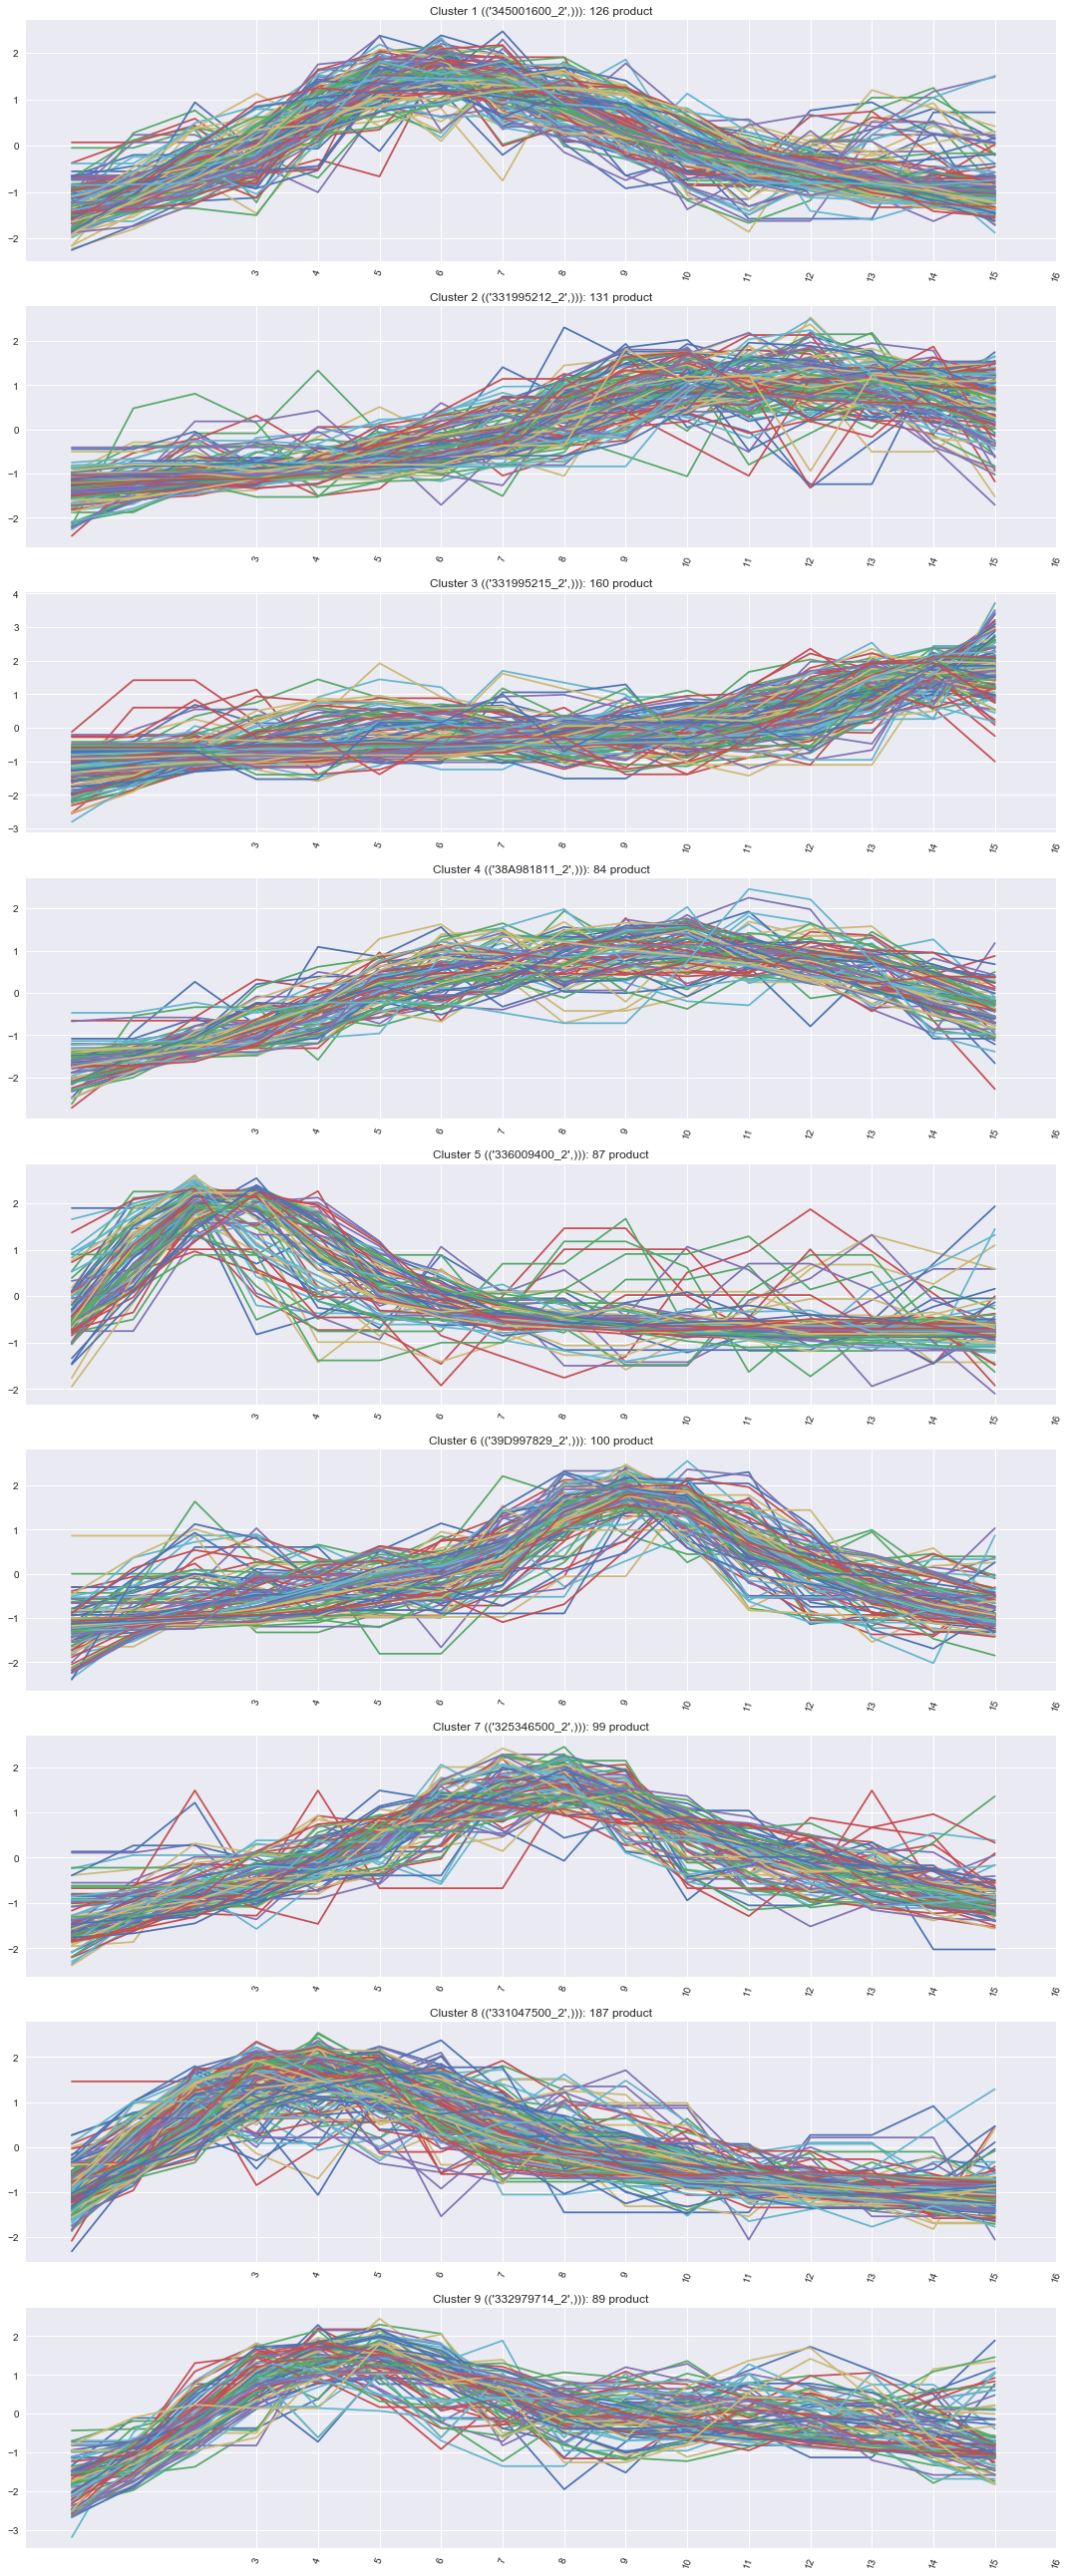

In [253]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df,headers = row_headers,tick_frequency = 1)
plt.show()

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = corr_df,headers = row_headers)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = spear_df,headers = row_headers)

SyntaxError: unexpected EOF while parsing (<unknown>, line 1)

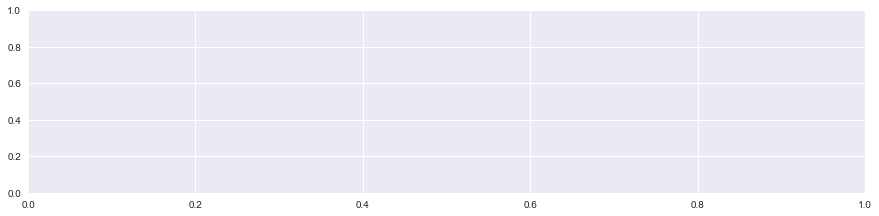

In [380]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df,headers = row_headers,centroid_only = True)

########################################################################################################################

########################################################################################################################

# Other Methods

## BIRCH Algorithm

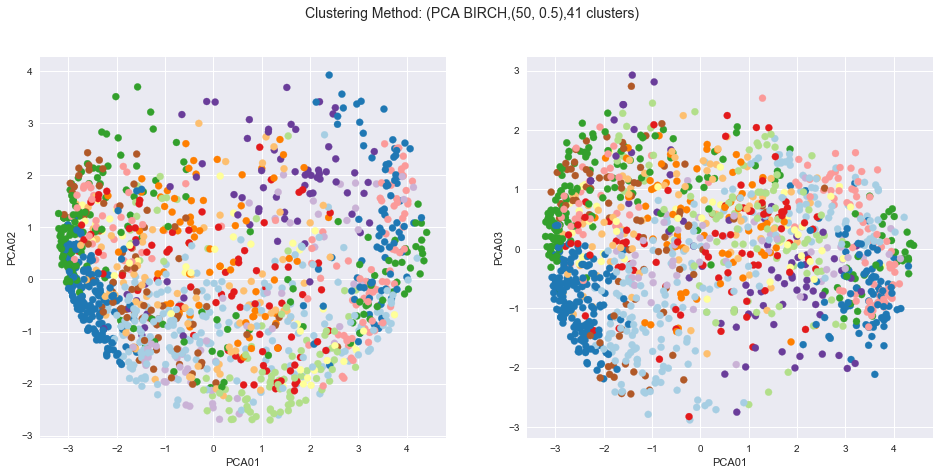

In [90]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

## SOM

In [ ]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.01) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()


# SOM with SOMpy

In [23]:
import sompy
mapsize = [30,30]

n_cluster = 50

som = sompy.SOMFactory().build(X_z, mapsize, mask=None, mapshape='rectangular', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  

som.train(n_job=1,train_rough_len=10, train_finetune_len=20,verbose=None)  
topographic_error  = som.calculate_topographic_error()
quantization_error = np.mean(som._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))
som_labels = som.cluster(n_cluster)+1

maxtrainlen %d inf
maxtrainlen %d inf
Topographic error = 0.161133244799; Quantization error = 1.24653106092


In [ ]:
som.component_names = np.arange(X_z.shape[1])
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8)  
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=6)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [50]:
bmus = som.project_data(X_z)

pkeys = product_df_full["Product"].values
referents = som_labels[bmus]

som_df =pd.DataFrame(np.vstack((pkeys,referents,pkeys[referents])).T,columns=["Product","Cluster","Centroid"]).set_index('Product')

file_name = "product_7cerf.txt"

non_unique_features=[]

code_features = []

unbalanced = ["Key_lvl2","Key_lvl7","Continuation of","Product Status",'Base Price 1 Coefficient Table',"Sales Season","Product ABC Classification"]

df_produit = pd.read_csv(raw_path+file_name, sep='\t',encoding="utf8")
product_cluster = df_produit.join(som_df,on="Key_lvl1",how='inner')

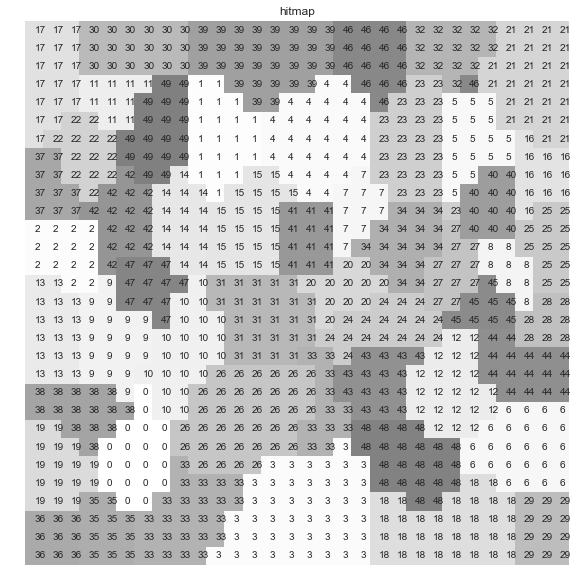

array([[  0,   0,   0],
       [  0,   1,   1],
       [  0,   2,   2],
       ..., 
       [ 29,  27, 897],
       [ 29,  28, 898],
       [ 29,  29, 899]])

In [51]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

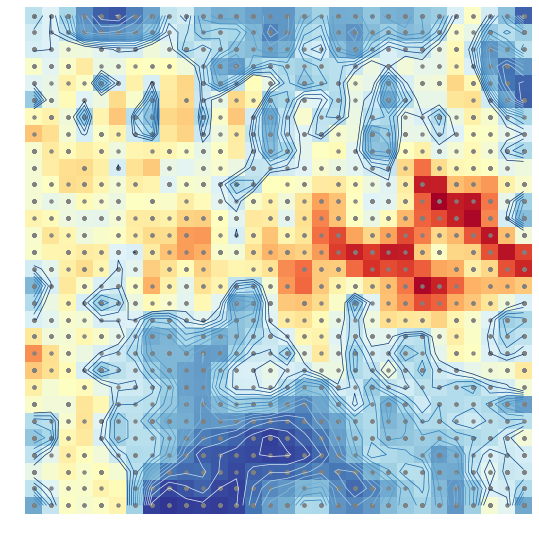

In [52]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)

# Fuzzy c-means

In [ ]:
import skfuzzy as fuzz

ncenters = n_cluster
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_z.T, ncenters, 2, error=0.005, maxiter=1000, init=None)



labels_fuzzy = np.argmax(u, axis=0)

## Representation methods
### PAA_SAX representation

In [ ]:
from pyts.transformation import PAA,SAX
from pyts.visualization import plot_paa, plot_sax
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
ts = X_z[0].reshape(1,-1)

paa_win = 100
sax_bin = 30


#PAA example
paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
X_paa = paa.transform(ts)
plot_paa(ts[0], window_size=None, output_size=paa_win, overlapping=True, marker='o')

#SAX example
sax = SAX(n_bins=sax_bin, quantiles='gaussian')
X_sax = sax.transform(X_paa)
plot_sax(X_paa[0], n_bins=sax_bin, quantiles='gaussian')
plt.show()

#Extract SAX vector
X_SAX= []
for x in X_z:
    ts = x.reshape(1,-1)
    paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
    X_paa = paa.transform(ts)
    sax = SAX(n_bins=sax_bin, quantiles='gaussian')
    X_sax = sax.transform(X_paa)[0]
    X_SAX.append(list(X_sax))

#Cast back to int
X_SAX = np.array(X_SAX).astype('|S1')
X_SAX = X_SAX.view(np.uint8) - 98
# X_z = X_SAX
# N,M  = X_z.shape


In [125]:
tuple([1,2,3])

(1, 2, 3)